https://keras.io/examples/generative/conditional_gan/ was used as a reference for the implementation of the conditional GAN.

In [1]:
# load libraries
import pickle

# imoprt data science libraries
import pandas as pd
from pandas import DataFrame as df
import numpy as np

# Import ML libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.metrics import geometric_mean_score

import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from keras import layers
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.models import Sequential

# local module with helper utils
import model_utils as mutils
from model_utils.evaluation import evaluate_model, get_metrics

In [3]:
current_k_fold = 3
# set seed
SEED=current_k_fold**3
np.random.seed(SEED)

# pandas options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# deserialize pre-processed data
path_to_pickle = f'../data/creditcard/cc13_preprocessed_k{current_k_fold}.pkl'


with open(path_to_pickle, "rb") as f:
    data = pickle.load(f)
    X_train = data["X_train"]
    y_train = data["y_train"]

    X_val = data["X_val"]
    y_val = data["y_val"]

    X_test = data["X_test"]
    y_test = data["y_test"]

    col_names = data["col_names"]

print("Data loaded successfully")

# get imbalance ratio for each data set
IR_train = mutils.imb_ratio(y_train.value_counts())
IR_val = mutils.imb_ratio(y_val.value_counts())
IR_test = mutils.imb_ratio(y_test.value_counts())

# print imbalance ratios. They should be (nearly) the same. pct = 0.172 such as in the paper!
print(f"Imbalance ratio in training data: {IR_train}")
print(f"Imbalance ratio in validation data: {IR_val}")
print(f"Imbalance ratio in test data: {IR_test}")

# print number of samples in each data set
print(f"\nNumber of samples in training data: {len(y_train)}")
print(f"Number of samples in validation data: {len(y_val)}")
print(f"Number of samples in test data: {len(y_test)}")

# # MinMax Scaling of dataset to [-1, 1] range
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## GAN specific pre-processing: Only use negative samples for training

X_train = X_train[y_train == 0].copy()
neg_y_train = y_train[y_train == 0].copy() # TODO: check if this is necessary

X_val = X_val[y_val == 0].copy()
neg_y_val = y_val[y_val == 0].copy()

Data loaded successfully
Imbalance ratio in training data: 599.48
Imbalance ratio in validation data: 602.68
Imbalance ratio in test data: 590.1

Number of samples in training data: 226980
Number of samples in validation data: 28373
Number of samples in test data: 28373


In [67]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,0.860332,0.575406,0.499508,-0.707871,0.088692,0.005544,-0.025708,0.567968,0.039230,-0.000013,-0.588978,0.483947,0.365601,0.285518,-0.028299,0.191400,0.427695,0.307986,0.377788,-0.181774,0.223463,0.071577,0.331697,-0.345626,0.185841,-0.290000,0.190715,-0.496334,-0.999219
1,0.870082,0.534899,0.630275,-0.370637,0.111048,0.076210,-0.029459,0.582794,-0.082287,-0.025927,-0.270101,0.461679,0.010800,0.214612,-0.242723,0.189819,0.533677,0.330005,0.197257,-0.154326,0.221440,0.071473,0.338966,-0.279866,0.256731,-0.208468,0.307555,-0.478681,-0.983952
2,0.908469,0.585987,0.402983,-0.525561,0.131308,-0.052055,-0.002057,0.573431,-0.098461,-0.061900,-0.204807,0.355744,-0.251465,0.088496,-0.216647,0.366693,0.622840,0.600910,0.043328,-0.170966,0.212943,0.029302,0.326145,-0.259136,0.241489,-0.121286,0.314561,-0.481386,-0.999148
3,0.874037,0.572652,0.558137,-0.757263,0.120139,0.022342,-0.002191,0.571319,-0.049391,0.007345,-0.364933,0.465825,0.139148,0.296451,-0.380007,0.308138,0.368528,0.270286,0.087933,-0.158693,0.200434,-0.055716,0.327337,-0.090650,0.273037,-0.032087,0.330847,-0.470961,-0.999491
4,0.811782,0.467900,0.599108,-0.487235,0.113499,-0.010017,-0.026977,0.576045,-0.006538,-0.028468,-0.598618,0.356780,-0.162561,0.302214,-0.074550,0.271154,0.420289,0.396233,0.087888,-0.119793,0.237248,0.077056,0.373597,-0.197635,0.262701,-0.118535,0.307514,-0.472342,-0.949126


<Axes: xlabel='Amount'>

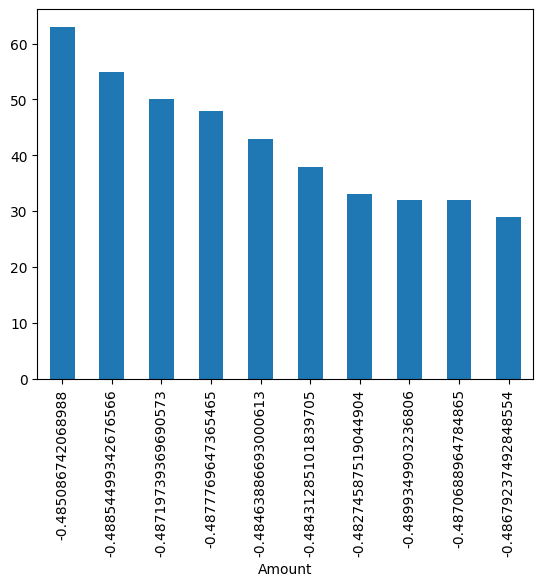

In [68]:
df_train = pd.DataFrame(X_train, columns=col_names[2:31])

df_train["Amount"].value_counts().head(10).plot(kind="bar")

In [7]:
data_dim = X_train.shape[1] # cols
latent_dim = 50

print(
	"X_train.shape: " , X_train.shape,
 	"\ndata_dim: ", data_dim,
 	"\nlatent_dim: ", latent_dim
)

X_train.shape:  (226602, 29) 
data_dim:  29 
latent_dim:  50


## Generator

In [8]:
# create generator model
def get_generator(latent_dim, data_dim):
    g = Sequential(name="generator")

    # Input layer
    g.add(
        layers.Input(shape=(latent_dim,), name="input")
    )  # input layer to receive noise from latent space
    g.add(Dense(128))
    g.add(LeakyReLU(negative_slope=0.2))
    g.add(BatchNormalization(momentum=0.8))
    # g.add(layers.Dropout(0.5))

    # Hidden layer 1: Upscale to a larger feature set
    g.add(Dense(256))
    g.add(LeakyReLU(negative_slope=0.2))
    g.add(BatchNormalization(momentum=0.8))
    # g.add(layers.Dropout(0.5))

    # Hidden layer 2: Continue upscaling
    g.add(Dense(512))
    g.add(LeakyReLU(negative_slope=0.2))
    g.add(BatchNormalization(momentum=0.8))
    g.add(layers.Dropout(0.5))

    g.add(Dense(data_dim, activation="tanh"))  # data_dim == cols

    return g


# httns://www.kaggle.com/code/utkarshroy17/credit-card-fraud-detection-using-gan
g_test = get_generator(latent_dim=latent_dim, data_dim=data_dim)
# g_test.summary()

mu, sigma = 0, 1  # mean and standard deviation
random_noise = np.random.normal(mu, sigma, size=[1, latent_dim])

test_fake_samples = g_test.predict(random_noise)

df_fake_samples = df(test_fake_samples)
df_fake_samples.columns = col_names[2:31]  # without idx, label
df_fake_samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,label
0,0.336362,-0.222427,-0.095486,0.480978,-0.012307,-0.206457,0.131855,-0.25876,-0.121199,-0.055773,-0.288379,-0.363772,-0.511688,0.294312,0.371632,-0.332194,0.127752,-0.083643,0.110944,-0.443964,0.041109,-0.104826,0.157612,-0.136587,0.015558,0.434486,0.014982,0.212569,0.214885


## Discriminator

 todo: add drop out

In [9]:
# create discriminator model
def get_discriminator(data_dim):
    d = Sequential(name="discriminator")

    # Input layer
    d.add(layers.Input(shape=(data_dim,)))
    d.add(layers.Dense(64, kernel_initializer="he_uniform"))
    d.add(LeakyReLU(negative_slope=0.2))

    # Hidden layer 1
    d.add(layers.Dense(64, kernel_initializer="he_uniform"))
    d.add(layers.LeakyReLU(negative_slope=0.2))

    # Hidden layer 2
    d.add(layers.Dense(32, kernel_initializer="he_uniform"))
    d.add(layers.LeakyReLU(negative_slope=0.2))

    # Output layer: single probability score
    d.add(layers.Dense(1, activation="sigmoid"))

    return d

In [22]:
# test discriminator
d_test = get_discriminator(data_dim=data_dim)
d_test.predict(test_fake_samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


array([[0.75684017]], dtype=float32)

## Build GAN network

In [10]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.g_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.seed_generator = keras.random.SeedGenerator(SEED)

    @property
    def metrics(self):
        return [self.d_loss_tracker, self.g_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_samples = data

        # Create random noise
        batch_size = tf.shape(real_samples)[0]  # Dynamically compute the batch size
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake samples
        fake_samples = self.generator(noise, training=True)

        # Combine fake and real samples and labels
        combined_samples = tf.concat([fake_samples, real_samples], axis=0)
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
        
        # Add random noise to the labels - important trick!
        labels += 0.05 * keras.random.uniform(
            tf.shape(labels), seed=self.seed_generator
        )
        
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_samples, training=True)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))
        
        # Train the generator
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1)) # Flip labels: real = fake
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(noise, training=True), training=False)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
        
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)

        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result()
        }
        
    # TODO: do we need this?
    def test_step(self, data):
        # Unpack the data
        real_samples, real_labels = data
        batch_size = tf.shape(real_samples)[0]

        # Generate noise
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # Generate fake samples using the generator
        fake_samples = self.generator(noise, training=False)
        
        # Labels for fake samples
        fake_labels = tf.zeros((batch_size, 1))
        
        # Evaluate discriminator on real samples
        real_predictions = self.discriminator(real_samples, training=False)
        d_loss_real = self.loss_fn(real_labels, real_predictions)
        
        # Evaluate discriminator on fake samples
        fake_predictions = self.discriminator(fake_samples, training=False)
        d_loss_fake = self.loss_fn(fake_labels, fake_predictions)

        # Overall discriminator loss on test data
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        
        # Update the loss trackers
        self.d_loss_tracker.update_state(d_loss)
    
        
        return {
            "d_loss": self.d_loss_tracker.result(),
        }
    

In [11]:
# hyperparams
epochs = 50
latent_dim = 29 # 29 features # Caution: previously defined in notebook!
batch_size = 100 # tried, 32, 64, 256, 512

# batch dataset
dataset = tf.data.Dataset.from_tensor_slices(X_train.astype(np.float32)) 
batches = dataset.shuffle(buffer_size=1024).batch(batch_size)  # Batch the dataset

In [12]:
# build and fit GAN
discriminator = get_discriminator(data_dim)
generator = get_generator(latent_dim=latent_dim, data_dim=data_dim)

# early stopping
cb_early_stopping_d = keras.callbacks.EarlyStopping(
    monitor="d_loss", mode="min", patience=10, restore_best_weights=False, baseline=0.2
)

cb_ckp_saver = keras.callbacks.ModelCheckpoint(f"./ckp/GAN_CC/k{current_k_fold}"+"epoch_{epoch}.keras")


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.build((None, data_dim))

gan.compile(
    d_optimizer=keras.optimizers.SGD(learning_rate=0.0002),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=False),
)

# let's train it
hist = gan.fit(
    batches,
    epochs=epochs,
    callbacks=[cb_early_stopping_d, cb_ckp_saver],
    validation_data=(X_val, neg_y_val),
)
# do not forget to save gan and d, g

# load gan_cc.keras
# discriminator = gan.discriminator
# discriminator = keras.models.load_model('./saved_models/GAN/discriminator_cc_1.keras')
# or load weights for gan / disc / gen

In [57]:
# getting best epoch 
metric_history = hist.history["val_d_loss"]
best_epoch = metric_history.index(min(metric_history)) + 1
print("Best epoch: ", best_epoch, "Best Value: ", min(metric_history))

# best_epoch=19
# gan.load_weights(f"./ckp/GAN_CC/k{current_k_fold}epoch_{best_epoch}.keras")

In [58]:
print("Mean score anomalous data: ", discriminator.predict(X_test[y_test == 1], verbose=0).mean())
print("Mean score normal data: ", discriminator.predict(X_test[y_test == 0], verbose=0).mean())

Mean score anomalous data:  0.1980712
Mean score normal data:  0.57268757


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
886/886 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


<Axes: title={'center': 'Normal'}, ylabel='Frequency'>

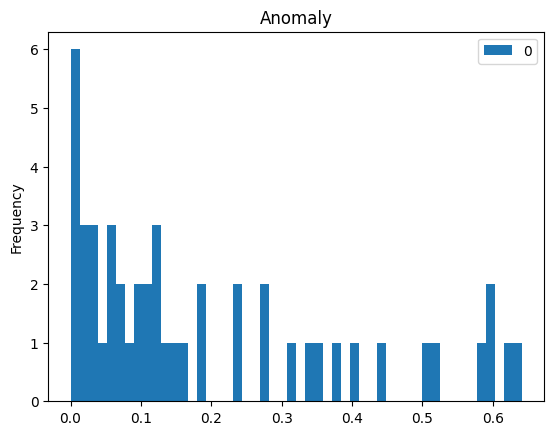

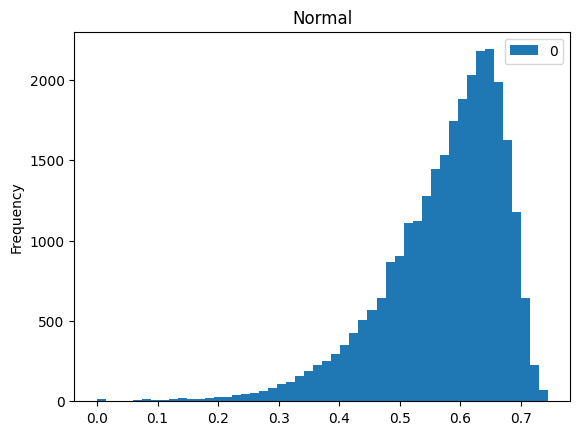

In [59]:
anomalies = X_test[y_test == 1]
normals = X_test[y_test == 0]

pred_proba_anomalies = pd.DataFrame(discriminator.predict(anomalies))
pred_proba_normals = pd.DataFrame(discriminator.predict(normals))

pred_proba_anomalies.plot(kind='hist', bins=50, title='Anomaly')
pred_proba_normals.plot(kind='hist', bins=50, title='Normal')
# pred_proba_anomalies.plot(kind='box', title='Anomaly')
# pred_proba_normals.plot(kind='box', title='Normal')

In [132]:
# Continuous scores from the discriminator
anomalous_scores = discriminator.predict(X_test[y_test == 1], verbose=0)
normal_scores = discriminator.predict(X_test[y_test == 0], verbose=0)

# True labels
y_true = np.concatenate([np.ones_like(anomalous_scores), np.zeros_like(normal_scores)])
scores = np.concatenate([anomalous_scores, normal_scores])

In [ ]:
best_metric = 0.
best_th = 0.

for threshold in np.arange(0.1, 1, 0.001):
    current_metric = get_metrics(y_true, scores.flatten(), op="<", threshold=threshold)["AUCPRC"]
    if current_metric > best_metric:
        best_metric = current_metric
        best_th = threshold

print("Best Metric Score:", best_metric)
print("Best Threshold: ", best_th)

In [134]:
get_metrics(y_true, scores.flatten(), op="<", threshold=best_th)

{'tn': 28267.0,
 'fp': 58.0,
 'fn': 21.0,
 'tp': 27.0,
 'precision': 0.3176,
 'recall': 0.5625,
 'AUCPRC': 0.0009,
 'F1': 0.406,
 'ROCAUC': 0.0551,
 'MCC': 0.4214,
 'ACC': 0.9972,
 'GMEAN': 0.7492}

In [ ]:
# save the model

gan.save_weights('./saved_models/GAN/gan_cc_2.weights.h5')
discriminator.save_weights('./saved_models/GAN/discriminator_cc_2.weights.h5')
generator.save_weights('./saved_models/GAN/generator_cc_2.weights.h5')

gan.save('./saved_models/GAN/gan_cc_2.keras')
discriminator.save('./saved_models/GAN/discriminator_cc_2.keras')
generator.save('./saved_models/GAN/generator_cc_2.keras')

print('Model saved.')
